<a href="https://colab.research.google.com/github/nrlarini03/Deep-Learning-CNN/blob/main/Deep_learning_CNN_G_211_22_0047.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving apple.webp to apple.webp


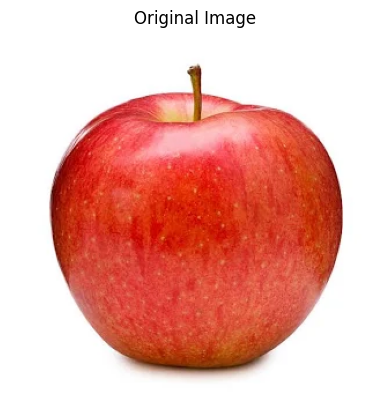

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Fungsi bantu untuk menampilkan gambar
def show(img, title="Image"):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Upload manual atau pakai gambar dari file lokal
from google.colab import files
uploaded = files.upload()

# Baca gambar (ubah nama sesuai file kamu)
img = cv2.imread("apple.webp")
show(img, "Original Image")

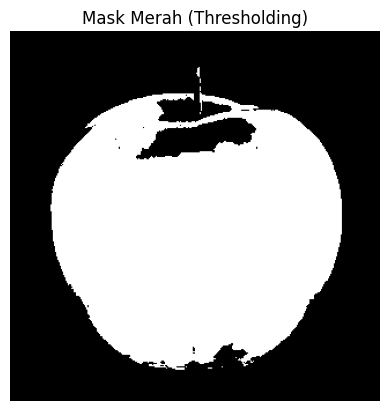

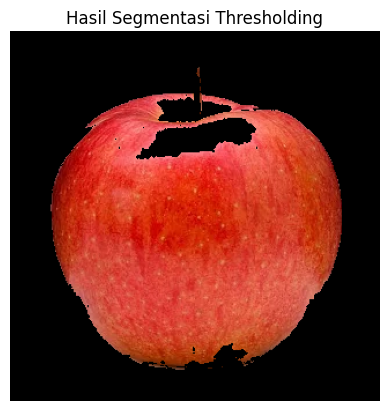

In [ ]:

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Rentang warna merah di HSV (dua range karena merah di ujung color circle)
lower_red1 = np.array([0, 120, 70])
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 120, 70])
upper_red2 = np.array([180, 255, 255])

mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
mask = mask1 + mask2

result = cv2.bitwise_and(img, img, mask=mask)
show(mask, "Mask Merah (Thresholding)")
show(result, "Hasil Segmentasi Thresholding")

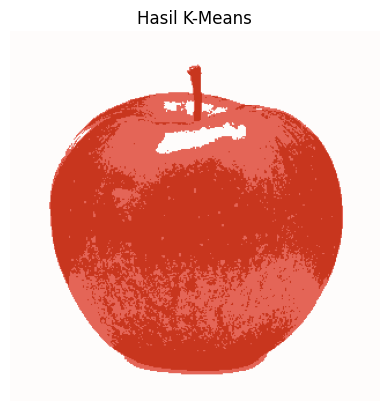

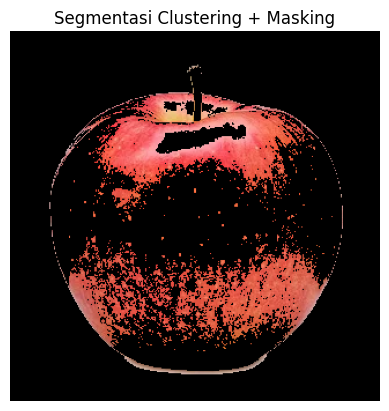

In [ ]:

# Ubah ke data 2D untuk clustering
data = img.reshape((-1, 3))
data = np.float32(data)

# K-Means
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3  # jumlah cluster warna
_, labels, centers = cv2.kmeans(data, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert hasil
centers = np.uint8(centers)
segmented = centers[labels.flatten()].reshape(img.shape)

show(segmented, "Hasil K-Means")

# Masking warna merah dari hasil clustering
red_cluster = [centers[i] for i in range(K) if centers[i][2] > 150][0]
mask_cluster = cv2.inRange(segmented, red_cluster-20, red_cluster+20)
hasil_cluster = cv2.bitwise_and(img, img, mask=mask_cluster)
show(hasil_cluster, "Segmentasi Clustering + Masking")

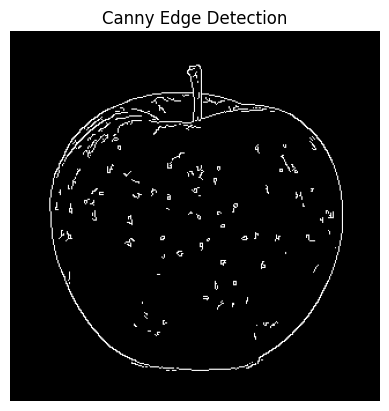

In [ ]:

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 100, 200)
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')
plt.show()

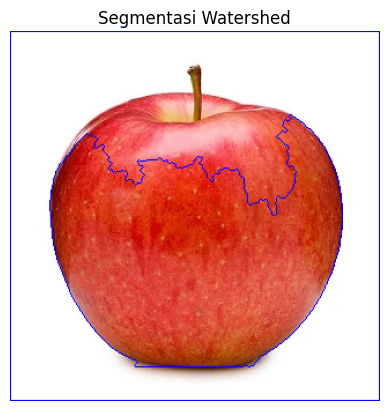

In [ ]:

# Grayscale & threshold
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal & markers
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background & foreground
sure_bg = cv2.dilate(opening, kernel, iterations=3)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Convert markers
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Watershed
markers = cv2.watershed(img, markers)
img[markers == -1] = [255, 0, 0]

show(img, "Segmentasi Watershed")